<a href="https://colab.research.google.com/github/Vaycold/Python_ML/blob/main/Reco_Algo/%233.Movielens%20Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 전처리

In [1]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df  = pd.io.parsers.read_csv(rating_url, names = ['user_id', 'movie_id', 'rating','time'], delimiter = '::',engine='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df  =  pd.io.parsers.read_csv(rating_url, names = [ 'movie_id', 'title','genre'], delimiter = '::',engine='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
1,1193,5,978300760
1,661,3,978302109
1,914,3,978301968
1,3408,4,978300275
1,2355,5,978824291


In [3]:
print(f'movie_df : {movie_df.shape}')
print(f'rating_df : {rating_df.shape}')

movie_df : (1000209, 3)
rating_df : (1000209, 4)


In [4]:
# 사용자 수 및 영화 갯수

print(f'유저 아이디 수 : {len(rating_df["user_id"].unique())}')
print(f'영화의 개수  : {len(rating_df["movie_id"].unique())}')


유저 아이디 수 : 6040
영화의 개수  : 3706


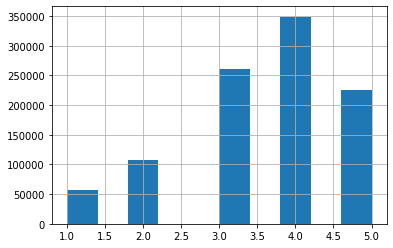

In [5]:
# 영화 점수 분포 탐색
import matplotlib.pyplot as plt
rating_df['rating'].hist()

In [3]:
!pip install surprise

In [4]:
# 추천 결과 평가 - 사용자별 전체 시청리스트 추출
user_watch_dict_list = rating_df.groupby('user_id')[['user_id','movie_id']].apply(lambda x : x['movie_id'].tolist())
user_watch_dict_list

user_id
1       [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2       [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3       [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4       [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5       [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
                              ...                        
6036    [571, 574, 2053, 2054, 2058, 588, 589, 4, 3005...
6037    [589, 3006, 1407, 2064, 2065, 593, 3015, 903, ...
6038    [1419, 920, 3088, 232, 1136, 1148, 1183, 2146,...
6039    [588, 2067, 1416, 3022, 3028, 2080, 2083, 2087...
6040    [573, 589, 1, 2068, 592, 593, 3016, 3017, 2070...
Length: 6040, dtype: object

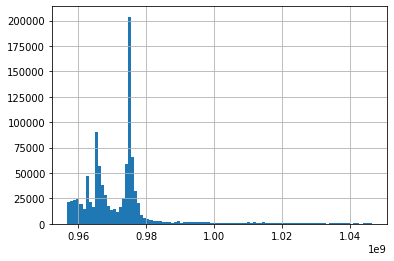

In [5]:
# 특정 시간 기준 사용자별 train / test 시청리스트 추출
rating_df['time'].hist(bins=100)

In [6]:
rating_df['time'].quantile(0.8, interpolation = 'nearest')

975768738

In [7]:
train_df = rating_df[rating_df['time'] < 975768738][['user_id', 'movie_id', 'rating']]
test_df = rating_df[rating_df['time'] >= 975768738][['user_id', 'movie_id', 'rating']]
print(f' rating df shape : {rating_df.shape}')
print(f' train df shape : {train_df.shape}')
print(f' test df shape : {test_df.shape}')

 rating df shape : (1000209, 4)
 train df shape : (800164, 3)
 test df shape : (200045, 3)


In [8]:
len(set(train_df['user_id']))

5400

In [9]:
len(set(test_df['user_id']))

1783

In [10]:
# 모델 기반 사용자별 선호 시청리스트 추출
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

reader = Reader(rating_scale = (1,5))
data = Dataset.load_from_df(train_df, reader=reader)
train_data = data.build_full_trainset()
algo = SVD(n_factors=50)
algo.fit(train_data)

In [11]:
test_data = train_data.build_anti_testset() # ?에 해당하는 값을 추출하게 됨, 아직 시청하지 않은 값들을 캐옴

In [37]:
predictions = algo.test(test_data[:20])

In [38]:
predictions

[Prediction(uid=635, iid=2054, r_ui=3.590506446178533, est=3.3421736263721376, details={'was_impossible': False}),
 Prediction(uid=635, iid=589, r_ui=3.590506446178533, est=4.1910090147434165, details={'was_impossible': False}),
 Prediction(uid=635, iid=1261, r_ui=3.590506446178533, est=4.172051171297118, details={'was_impossible': False}),
 Prediction(uid=635, iid=3016, r_ui=3.590506446178533, est=3.7736488470103517, details={'was_impossible': False}),
 Prediction(uid=635, iid=1274, r_ui=3.590506446178533, est=4.300482807112005, details={'was_impossible': False}),
 Prediction(uid=635, iid=2094, r_ui=3.590506446178533, est=3.360595614750531, details={'was_impossible': False}),
 Prediction(uid=635, iid=780, r_ui=3.590506446178533, est=3.735343303012632, details={'was_impossible': False}),
 Prediction(uid=635, iid=1603, r_ui=3.590506446178533, est=3.384434072152226, details={'was_impossible': False}),
 Prediction(uid=635, iid=2288, r_ui=3.590506446178533, est=4.33627957866017, details={'

In [12]:
# 추천 결과 평가
predictions = algo.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions :
    if uid in estimated_unwatched_dict :
        estimated_unwatched_dict[uid].append((iid, predicted_rating))
    else :
        estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

In [14]:
# 4점 이상을 준 test 시청리스트만 추출

user_watch_dict_list_test = test_df[test_df['rating']>=4].groupby('user_id')[['user_id','movie_id']].apply(lambda x : x['movie_id'].tolist())

In [ ]:
user_metric = []
# 유저별 k개의 선호리스트 추출
k = 3 
for user in estimated_unwatched_dict :
    estimated_list = estimated_unwatched_dict[user].copy()
    estimated_list.sort(key=lambda tup:tup[1], reverse=True)
    try :
        top_k_prefer_list = [movie[0] for movie in estimated_list[:k]]
        actual_watch_list = user_watch_dict_list_test[int(user)]
        user_metric.append((user,top_k_prefer_list,actual_watch_list))
    except :
        print('exclude user : ' + str(user))

In [ ]:
user_metric[:2]

In [20]:
# 유저 1명의 Precision
predict_value = user_metric[0][1]
actual_value = user_metric[0][2]
TruePositive = [pv for pv in predict_value if pv in actual_value]
len(TruePositive) / len(predict_value)

0.0

In [23]:
def get_map(user_list) :
    precision_list = []
    for user in user_list :
        predict_value = user[1]
        actual_value = set(user[2])
        tp = [pv for pv in predict_value if pv in actual_value]
        precision = len(tp) / len(predict_value)
        precision_list.append(precision)
    return sum(precision_list) / len(precision_list)



In [24]:
get_map(user_metric)

0.15062388591800355